In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
from healpy.visufunc import projplot
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, angular_separation, Angle
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
import dipole

In [3]:
plt.rcParams.update({
    'text.usetex' : False,
    'font.family' : 'serif'
})

### CMB dipole

In [4]:
cmb_amp, cmb_dir = dipole.cmb_dipole(frame='galactic')

### Quaia

#### dipoles with old selection function

In [5]:
quaia_kwargs = dict(initial_catfn='quaia_G20.5.fits',
                      catname='quaia', mag='G', load_init=False, compcorrect=True)

# galactic plane
blims = np.arange(15, 71, 5)
old_dipoles_bcut = []
for i, blim in enumerate(blims):
    d = SecrestDipole(blim=blim, maglim=20., **quaia_kwargs)
    d.savedir_ = os.path.join('/scratch/aew492/quasars/catalogs/quaia/choices/old_selfunc_30-11-23',
                             f'quaia_{d.mag}{d.maglim:.1f}_blim{d.blim:.0f}{d.save_tag}/comp-corrected')
    map_ = d.load_hpxelatcorr()
    old_dipoles_bcut.append(d.compute_dipole(map_))

# magnitude limit
maglims = np.arange(19., 20.51, 0.1)
old_dipoles_maglims = []
for i, maglim in enumerate(maglims):
    d = SecrestDipole(maglim=maglim, blim=30, **quaia_kwargs)
    d.savedir_ = os.path.join('/scratch/aew492/quasars/catalogs/quaia/choices/old_selfunc_30-11-23',
                             f'quaia_{d.mag}{d.maglim:.1f}_blim{d.blim:.0f}{d.save_tag}/comp-corrected')
    map_ = d.load_hpxelatcorr()
    old_dipoles_maglims.append(d.compute_dipole(map_))

# mask radii
factors = np.array([0., 0.2, 0.5, 1., 1.5, 2., 2.5])
old_dipoles_masks = []
for i, factor in enumerate(factors):
    save_tag = f'_r{factor:.1f}'
    d = SecrestDipole(save_tag=save_tag, maglim=20., blim=30, **quaia_kwargs)
    d.savedir_ = os.path.join('/scratch/aew492/quasars/catalogs/quaia/choices/old_selfunc_30-11-23',
                             f'quaia_{d.mag}{d.maglim:.1f}_blim{d.blim:.0f}{d.save_tag}/comp-corrected')
    map_ = d.load_hpxelatcorr()
    old_dipoles_masks.append(d.compute_dipole(map_))

#### dipoles with new selection function

In [6]:
# galactic plane
dipoles_bcut = []
for i, blim in enumerate(blims):
    d = SecrestDipole(blim=blim, maglim=20., save_tag='_r1.0', **quaia_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_bcut.append(d.compute_dipole(map_))

# magnitude limit
dipoles_maglims = []
for i, maglim in enumerate(maglims):
    d = SecrestDipole(maglim=maglim, blim=30, save_tag='_r1.0', **quaia_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_maglims.append(d.compute_dipole(map_))

# mask radii
dipoles_masks = []
for i, factor in enumerate(factors):
    save_tag = f'_r{factor:.1f}'
    d = SecrestDipole(save_tag=save_tag, maglim=20., blim=30, **quaia_kwargs)
    map_ = d.load_hpxelatcorr()
    dipoles_masks.append(d.compute_dipole(map_))

#### compare

In [7]:
# prep for plotting
# old
dips_b_old = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in old_dipoles_bcut
])
dips_maglims_old = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in old_dipoles_maglims
])
dips_masks_old = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in old_dipoles_masks
])

# new
dips_b = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_bcut
])
dips_maglims = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_maglims
])
dips_masks = np.array([
    [x[0], x[1].l.deg, x[1].b.deg] for x in dipoles_masks
])

In [8]:
# fiducials
ifid = np.where(blims==30.)[0]
quaia_fid_old = dips_b_old[ifid].flatten()
quaia_fid = dips_b[ifid].flatten()

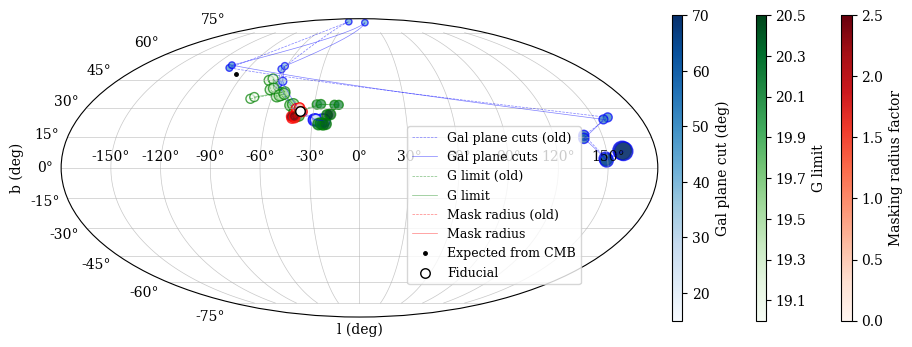

In [11]:
# color map
b_smap = mpl.cm.ScalarMappable(cmap='Blues',norm = mpl.colors.Normalize(vmin=min(blims), vmax=max(blims)))
r_smap = mpl.cm.ScalarMappable(cmap='Reds',norm = mpl.colors.Normalize(vmin=min(factors), vmax=max(factors)))
g_smap = mpl.cm.ScalarMappable(cmap='Greens',norm = mpl.colors.Normalize(vmin=min(maglims), vmax=max(maglims)))

# sky plot
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection='mollweide')

line_kwargs = dict(alpha=0.5, lw=0.5, marker='None')
kwargs = dict(marker='o', alpha=0.7)
a = 3000

# galactic plane
ax.plot(Angle(dips_b_old[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dips_b_old[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='b', label='Gal plane cuts (old)', ls='--', **line_kwargs)
bim = ax.scatter(Angle(dips_b_old[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 Angle(dips_b_old[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 s=a*dips_b_old[:,0], c=b_smap.to_rgba(blims), edgecolors='b', **kwargs)
ax.plot(Angle(dips_b[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dips_b[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='b', label='Gal plane cuts', **line_kwargs)
bim = ax.scatter(Angle(dips_b[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 Angle(dips_b[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 s=a*dips_b[:,0], c=b_smap.to_rgba(blims), edgecolors='b', **kwargs)

# magnitude limit
ax.plot(Angle(dips_maglims_old[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dips_maglims_old[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='g', label='G limit (old)', ls='--', **line_kwargs)
gim = ax.scatter(Angle(dips_maglims_old[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                  Angle(dips_maglims_old[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                  s=a*dips_maglims_old[:,0], c=g_smap.to_rgba(maglims), edgecolors='g', **kwargs)
ax.plot(Angle(dips_maglims[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dips_maglims[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='g', label='G limit', **line_kwargs)
gim = ax.scatter(Angle(dips_maglims[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                  Angle(dips_maglims[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                  s=a*dips_maglims[:,0], c=g_smap.to_rgba(maglims), edgecolors='g', **kwargs)

# mask radii
ax.plot(Angle(dips_masks_old[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dips_masks_old[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='r', label='Mask radius (old)', ls='--', **line_kwargs)
rim = ax.scatter(Angle(dips_masks_old[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 Angle(dips_masks_old[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 s=a*dips_masks_old[:,0], c=r_smap.to_rgba(factors), edgecolors='r', **kwargs)
ax.plot(Angle(dips_masks[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        Angle(dips_masks[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
        c='r', label='Mask radius', **line_kwargs)
rim = ax.scatter(Angle(dips_masks[:,1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 Angle(dips_masks[:,2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
                 s=a*dips_masks[:,0], c=r_smap.to_rgba(factors), edgecolors='r', **kwargs)

# CMB
ax.plot(Angle(cmb_dir.l, unit=u.rad).wrap_at(np.pi*u.rad),
        Angle(cmb_dir.b, unit=u.rad).wrap_at(np.pi*u.rad),
        marker='o', ls='None', ms=500*0.005, alpha=1., c='k', zorder=11, label='Expected from CMB')
# Quaia fiducial
ax.scatter(Angle(quaia_fid[1], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
           Angle(quaia_fid[2], unit='deg').to(u.rad).wrap_at(np.pi*u.rad),
           marker='o', c='w', edgecolors='k', s=a*quaia_fid[0],
            zorder=10, label='Fiducial')

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
ax.legend(loc=(.58,.11), fontsize=9)
cbar_kwargs = dict(shrink=0.65, aspect=30, fraction=.15)
fig.colorbar(r_smap, ax=ax, pad=-.04, label='Masking radius factor', **cbar_kwargs)
cbar = fig.colorbar(g_smap, ax=ax, pad=-.03, label='G limit', **cbar_kwargs)
cbar.ax.set_yticks(np.arange(19.1, 20.51, 0.2), labels=[
    f'{x:.1f}' for x in np.arange(19.1, 20.51, 0.2)
])
fig.colorbar(b_smap, ax=ax, pad=.02, label='Gal plane cut (deg)', **cbar_kwargs)
# ax.set_title('S21 recovered dipoles')
ax.grid(True, lw=0.5, alpha=0.7)
fig.tight_layout()

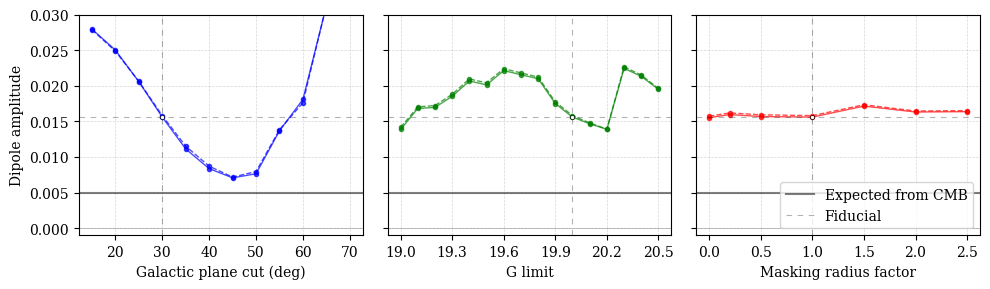

In [10]:
# amplitudes
fig, axs = plt.subplots(1, 3, figsize=(10,3))

kwargs = dict(lw=1, alpha=0.7, marker='.')

# galactic plane
axs[0].plot(blims, dips_b_old[:,0], c='b', ls='--', **kwargs)
axs[0].plot(blims, dips_b[:,0], c='b', **kwargs)
axs[0].set_xlabel('Galactic plane cut (deg)')
axs[0].axvline(30., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[0].plot(30., dips_b[:,0][blims==30.], marker='.', c='w', mec='k', mew=0.5, zorder=10)
axs[0].set_xticks(np.arange(20, 71, 10))
# magnitude limit
axs[1].plot(maglims, dips_maglims_old[:,0], c='g', ls='--', **kwargs)
axs[1].plot(maglims, dips_maglims[:,0], c='g', **kwargs)
axs[1].set_xlabel('G limit')
axs[1].axvline(20., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[1].plot(20., dips_b[:,0][blims==30.], marker='.', c='w', mec='k', mew=0.5, zorder=10)
axs[1].set_xticks(np.arange(19., 20.51, 0.3))
# mask radii
axs[2].plot(factors, dips_masks_old[:,0], c='r', ls='--', **kwargs)
axs[2].plot(factors, dips_masks[:,0], c='r', **kwargs)
axs[2].set_xlabel('Masking radius factor')
axs[2].axvline(1., alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8)
axs[2].plot(1., dips_masks[:,0][factors==1.], marker='.', c='w', mec='k', mew=0.5, zorder=10)

# CMB and other formatting
for ax in axs:
    ax.set_yticks(np.arange(0, 0.0351, 0.005))
    ax.grid(lw=0.5, alpha=0.5, ls='--')
    ax.axhline(0.005, c='k', label='Expected from CMB', alpha=0.5, lw=1.5)
    ax.set_ylim(-.001, 0.03)
    ax.axhline(0, alpha=0.3, color='k', lw=0.5)
    ax.axhline(quaia_fid[0], alpha=0.3, c='k', ls=(0,(5,5)), lw=0.8, label='Fiducial')
for ax in axs[1:]:
    ax.set_yticklabels([])
axs[0].set_ylabel('Dipole amplitude')
axs[-1].legend(loc=4)
fig.tight_layout()